In [1]:
import argparse
import os
from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torchvision import models, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchinfo import summary
from torch import autograd
import logging
from tqdm.auto import tqdm
from Model import WaveGANGenerator, WaveGANDiscriminator, Pulse2PulseGANGenerator

from ai4ha.util import instantiate_from_config, load_config
from ai4ha.GAN.losses import calc_gradient_penalty

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration
from diffusers.optimization import get_scheduler
from accelerate import DistributedDataParallelKwargs

In [2]:
def save_model(netG, netD, optimizerG, optimizerD, epoch):
    check_point_name = py_file_name + "_epoch:{}.pt".format(
        epoch
    )  # get code file name and make a name
    check_point_path = os.path.join(checkpoint_dir, check_point_name)
    # save torch model
    torch.save(
        {
            "epoch": epoch,
            "netG_state_dict": netG.state_dict(),
            "netD_state_dict": netD.state_dict(),
            "optimizerG_state_dict": optimizerG.state_dict(),
            "optimizerD_state_dict": optimizerD.state_dict(),
            # "train_loss": train_loss,
            # "val_loss": validation_loss
        },
        check_point_path,
    )

In [3]:
DIRS = ['checkpoints', 'logs', 'samples', "final", "model"]
logger = get_logger(__name__, log_level="INFO")

In [4]:
config = load_config('configs/done/Pulse2Pulse-MITBIH-G-NL3-IC32-K8-S2-BN-D-NL3-IC16-K4-S2-P1-SF2-SN-local.json')

In [5]:
BASE_DIR = f"{config['exp_dir']}/logs/{config['name']}"

for dir in DIRS:
    os.makedirs(f"{BASE_DIR}/{dir}", exist_ok=True)

accparams = config['accelerator']
# accparams["logging_dir"] = f"{BASE_DIR}/logs"
accparams["project_dir"] = BASE_DIR

if 'projectconf' in config:
    accparams['project_config'] = ProjectConfiguration(**config['projectconf'])

ddp_kwargs = DistributedDataParallelKwargs(
    find_unused_parameters=accparams['gradient_accumulation_steps'] > 1)
accelerator = Accelerator(**accparams, kwargs_handlers=[ddp_kwargs])

/home/bejar/env/torch13/lib/python3.10/site-packages/accelerate/accelerator.py:371: UserWarning: `log_with=wandb` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


In [6]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)

02/29/2024 11:19:57 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



In [7]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# netG = WaveGANGenerator(
#     latent_dim=config['model']['generator']['latent_dim'],
#     output_channels=config['model']['generator']['output_channels'],
#     init_dim=config['model']['generator']['init_dim'],
#     output_size=config['model']['generator']['output_size'],
#     kernel_size=config['model']['generator']['kernel_size'],
#     stride=config['model']['generator']['stride'],
#     batch_norm=config['model']['generator']['batch_norm'],
#     n_classes=config['model']['generator']['n_classes'],
# )

netG = Pulse2PulseGANGenerator(
    seq_length=config['model']['generator']['seq_length'],
    seq_channels=config['model']['generator']['seq_channels'],
    init_channels=config['model']['generator']['init_channels'],
    n_layers=config['model']['generator']['n_layers'],
    kernel_size=config['model']['generator']['kernel_size'],
    stride=config['model']['generator']['stride'],
    batch_norm=config['model']['generator']['batch_norm'],
    n_classes=config['model']['generator']['n_classes'],
)

netD = WaveGANDiscriminator(
    input_size=config['model']['discriminator']['input_size'],
    input_channels=config['model']['discriminator']['input_channels'],
    init_channels=config['model']['discriminator']['init_channels'],
    n_layers=config['model']['discriminator']['n_layers'],
    kernel_size=config['model']['discriminator']['kernel_size'],
    stride=config['model']['discriminator']['stride'],
    padding=config['model']['discriminator']['padding'],
    shift_factor=config['model']['discriminator']['shift_factor'],
    n_classes=config['model']['discriminator']['n_classes'],)

In [9]:
# noise = torch.randn(16, 100)
# fake = netG(noise)
# print(fake.shape)

In [10]:
optimizerG = optim.Adam(netG.parameters(),
                        lr=config['optimizer']['lr'],
                        betas=(config['optimizer']['beta1'],
                               config['optimizer']['beta2']))

optimizerD = optim.Adam(netD.parameters(),
                        lr=config['optimizer']['lr'],
                        betas=(config['optimizer']['beta1'],
                               config['optimizer']['beta2']))

In [11]:
train_data = instantiate_from_config(config['dataset']['train'])
test_data = instantiate_from_config(config['dataset']['test'])
train_dataloader = torch.utils.data.DataLoader(
    train_data, **config['dataset']["dataloader"])

Class 0 = (72471, 188)
Class 1 = (2223, 188)
Class 2 = (5788, 188)
Class 3 = (641, 188)
Class 4 = (6431, 188)
X_train shape is (87554, 1, 256)
y_train shape is (87554,)
--------------------------------
-------TEST DATA-------
Class 0 = (18118, 188)
Class 1 = (556, 188)
Class 2 = (1448, 188)
Class 3 = (162, 188)
Class 4 = (1608, 188)
X_test shape is (21892, 1, 256)
y_test shape is (21892,)


In [12]:
lr_schedulerD = get_scheduler(
    "cosine",
    optimizer=optimizerD,
    num_warmup_steps=config['train']['lr_warmup_steps'] *
    accparams['gradient_accumulation_steps'],
    num_training_steps=(len(train_dataloader) * config['train']['num_epochs']),
)
lr_schedulerG = get_scheduler(
    "cosine",
    optimizer=optimizerG,
    num_warmup_steps=config['train']['lr_warmup_steps'] *
    accparams['gradient_accumulation_steps'],
    num_training_steps=(len(train_dataloader) * config['train']['num_epochs']),
)

In [13]:
netD, netG, optimizerD, optimizerG, train_dataloader, lr_schedulerD, lr_schedulerG = accelerator.prepare(
    netD, netG, optimizerD, optimizerG, train_dataloader, lr_schedulerD, lr_schedulerG)
netD.to(accelerator.device)
netG.to(accelerator.device);

In [14]:
next(netG.parameters()).device

device(type='cuda', index=0)

In [15]:
start_epoch = 0
num_epochs = 1

In [74]:
num_update_steps_per_epoch = len(
    train_dataloader) // config['accelerator']['gradient_accumulation_steps']
batch_size = config['dataset']['dataloader']['batch_size']
latent_dim = config['models']['generator']['latent_dim']

lambda_gp = 0.1

for epoch in range(config['train']['num_epochs']):
    progress_bar = tqdm(total=num_update_steps_per_epoch,
                        disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    mean_lossG, mean_lossD = 0, 0
    for step, batch in enumerate(train_dataloader):
        # Discriminator update
        data, label = batch

        label = label.long().to(accelerator.device)
        data = data.float().to(accelerator.device)
        noise_dims = tuple([data.size(0)] + latent_dim)
        noise = torch.randn(*noise_dims).to(device)

        if config['model']['generator']['n_classes'] > 0:
            fake = netG(noise, label)
            pred_fake = netD(fake, label)
        else:
            label = None
            fake = netG(noise)
            pred_fake = netD(fake)

        loss_d_fake = pred_fake.mean()
        pred_real = netD(data, label)
        loss_d_real = pred_real.mean()

        gradient_penalty = calc_gradient_penalty(netD,
                                                 data,
                                                 fake,
                                                 labels=label)

        loss_d = loss_d_fake - loss_d_real + (lambda_gp * gradient_penalty)
        mean_lossD += loss_d.item()
        optimizerD.zero_grad()
        loss_d.backward()
        optimizerD.step()

        # Generator update
        noise = torch.randn(*noise_dims).to(device)

        if config['model']['generator']['n_classes'] > 0:
            fake = netG(noise, label)
            pred_fake = netD(fake, label)
        else:
            fake = netG(noise)
            pred_fake = netD(fake)
        loss_g = -pred_fake.mean()

        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()

        mean_lossG += loss_g.item()

        lr_schedulerD.step()
        lr_schedulerG.step()
        progress_bar.update(1)
        progress_bar.set_postfix({
            "lossD": f'{loss_d.item():6.5f}',
            "lossG": f'{loss_g.item():6.5f}',
            "mean_lossG": f'{mean_lossG / (step + 1):6.5f}',
            "mean_lossD": f'{mean_lossD / (step + 1):6.5f}'
        })

  0%|          | 0/5473 [00:00<?, ?it/s]

  0%|          | 0/5473 [00:00<?, ?it/s]

  0%|          | 0/5473 [00:00<?, ?it/s]

  0%|          | 0/5473 [00:00<?, ?it/s]

  0%|          | 0/5473 [00:00<?, ?it/s]

In [75]:
import matplotlib.pyplot as plt

In [88]:
noise = torch.randn(1,seq_channels, seq_length).to(device)
fake = netG(noise, torch.tensor([4]).to(device))

In [89]:
series = fake.squeeze().detach().cpu().numpy()

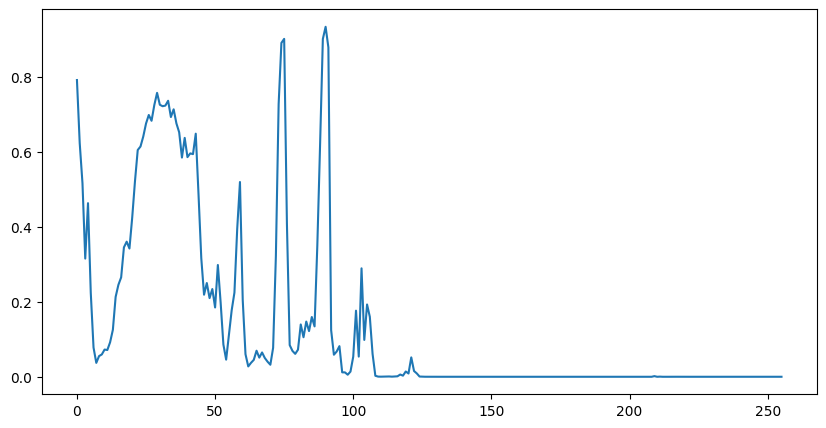

In [90]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.plot(series)